# Trade cost optimization

The following notebook is an attempt to understand and recreate the results from Scalable Capital's blog - https://de.scalable.capital/en/finances-stock-market/trade-cost-optimisation

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

%matplotlib inline

Use `yfinance` to download the data. The data considered in the blog spanned 10 years between 2008 and 2018. We will also consider the same data here and filter and use only the closing data of each day from the table

In [2]:
etfs = ["SHY", "TLT", "RWR", "IWM", "IWB", "GLD", "EFA", "EEM", "DBC"]

price = (
    yf.download(
        etfs,
        start="2008-01-01",
        end="2018-12-31",
        auto_adjust=True
    )["Close"]
    .dropna(how="all") # Drop rows with NaN values
)

[*********************100%***********************]  9 of 9 completed


In [3]:
price.head()

Ticker,DBC,EEM,EFA,GLD,IWB,IWM,RWR,SHY,TLT
Date,,,,,,,,,
2008-01-02,27.900320,34.392258,47.175972,84.860001,58.098831,59.295933,37.126713,63.854504,56.674713
2008-01-03,28.115402,34.701706,47.254383,85.570000,58.098831,58.641117,36.037945,63.955364,56.596642
2008-01-04,27.951942,33.659370,46.180824,85.129997,56.740662,56.873913,34.517948,64.048401,56.608624
2008-01-07,27.444349,33.906002,46.229069,84.769997,56.792294,57.000130,34.749725,64.009605,56.854881
2008-01-08,27.693840,33.643089,45.969719,86.779999,55.722000,55.240814,33.617805,64.102676,56.788818


Change the index to a datetime object and sort by it just to be sure

In [4]:
price.index = pd.to_datetime(price.index)
price = price.sort_index()

Computing the momentum assuming a simple 252 trading days in a year and leaving out the first 252 occurrences 

In [5]:
momentum = price.pct_change(periods=252).dropna()
momentum.head()

Ticker,DBC,EEM,EFA,GLD,IWB,IWM,RWR,SHY,TLT
Date,,,,,,,,,
2008-12-31,-0.336288,-0.480211,-0.408200,0.019562,-0.366983,-0.334923,-0.384081,0.064284,0.320499
2009-01-02,-0.318365,-0.460296,-0.401543,0.007713,-0.348330,-0.314112,-0.384259,0.056957,0.289083
2009-01-05,-0.307188,-0.436351,-0.397469,-0.007635,-0.331803,-0.290265,-0.375125,0.057553,0.255579
2009-01-06,-0.275906,-0.427782,-0.391636,0.004247,-0.328436,-0.279894,-0.344710,0.058695,0.237567
2009-01-07,-0.319033,-0.456507,-0.398763,-0.046439,-0.334309,-0.278852,-0.346981,0.056407,0.243866


The strategy is to select the top 5 performing ETFs with equal weights. For that we do the following
- Rank the ETFs on a daily basis based on the momentum
- Create equal weights for these top ETFs normalized to 1
- Average over a 21 day window for regularization

These constitute the ideal target weights if we don't do trade cost optimization

In [6]:
ranks = momentum.rank(axis=1, ascending=False, method="first")
ideal_weights = (ranks <= 5).astype(int) # Create a mask for the top 5
ideal_weights = ideal_weights.div(ideal_weights.sum(axis=1), axis=0).fillna(0.0) # Normalize to 1
ideal_weights = ideal_weights.rolling(21, min_periods=1).mean()
ideal_weights.tail()

Ticker,DBC,EEM,EFA,GLD,IWB,IWM,RWR,SHY,TLT
Date,,,,,,,,,
2018-12-21,0.085714,0.0,0.0,0.171429,0.200000,0.104762,0.2,0.2,0.038095
2018-12-24,0.085714,0.0,0.0,0.180952,0.190476,0.095238,0.2,0.2,0.047619
2018-12-26,0.085714,0.0,0.0,0.180952,0.190476,0.085714,0.2,0.2,0.057143
2018-12-27,0.085714,0.0,0.0,0.180952,0.190476,0.076190,0.2,0.2,0.066667
2018-12-28,0.085714,0.0,0.0,0.180952,0.190476,0.066667,0.2,0.2,0.076190


Now we include the trade costs and try to figure out how to optimize for a given value of $\delta$ and $\gamma$. An intuitive understanding of these two parameters is as follows
- $\delta$: Trading is triggered only when the turnover distance between between current weights $x_0$ and ideal weights $\tilde{x}$ is greater than $\delta$
- $\gamma$: After trade cost optimization that gives the solution weights $x$, trading is triggered only if the turnover distance between $x$ and $\tilde{x}$ is less than $\gamma$

Two assumptions here for the fee structure follow from the paper
- The fixed cost is 5$ per order
- The variable cost is set at 0.25% of the traded volume

It is rightly stated that standard solvers are not well suited for the task where the objective expression for the variable cost includes an absolute value function. But this can be overcome by using the `cp.abs()` function for now. The indicator variable, on the other hand that appears in the fixed cost part of the expression is indeed a problem. Here, we introduce MILP through a variable `y`

In [7]:
def trade_cost_optimizer(ideal_weights, gamma, delta):
    n = len(etfs)

    final_weights = pd.DataFrame(index=ideal_weights.index, columns=ideal_weights.columns)

    current_weights = ideal_weights.iloc[0].to_numpy().copy()
    for i in range(1,len(ideal_weights)):
        ideal_target_weights = ideal_weights.iloc[i].to_numpy().copy()
        turnover = np.sum(np.abs(ideal_target_weights - current_weights))/2
        
        # If the turnover is less than the threshold, we don't trade
        if turnover <= delta:
            final_weights.iloc[i] = current_weights
        else:
            # Solve linear program for the optimized weights
            # but constrained to stay within the gamma distance 
            # from the ideal target weights
            optimized_weights = cp.Variable(n)
            
            # Since cp doesn't support norm0, we need to use a binary variable
            y = cp.Variable(n, boolean=True)
            
            objective = cp.Minimize(
                    0.0025 * cp.norm1(optimized_weights - current_weights) + \
                    5 * cp.sum(y)
                )
            
            constraints = [
                cp.sum(optimized_weights) == 1,
                optimized_weights >= 0,
                cp.abs(optimized_weights - current_weights) <= y,
                cp.norm_inf(optimized_weights - ideal_target_weights) <= 2*gamma,
            ]
            prob = cp.Problem(objective, constraints)
            
            try:
                prob.solve(warm_start=True)
                final_weights.iloc[i] = optimized_weights.value
                current_weights = optimized_weights.value
            except cp.error.SolverError as e:
                print(f"Solver error: {e}")
                # Use the current weights as a fallback
                final_weights.iloc[i] = current_weights

        current_weights = final_weights.iloc[i].to_numpy().copy()

    return final_weights


In [8]:
optimized_weights_1 = trade_cost_optimizer(
    ideal_weights,
    gamma=0.025,
    delta=0.10
)

optimized_weights_2 = trade_cost_optimizer(
    ideal_weights,
    gamma=0.05,
    delta=0.15
)

Creating a function to backtest and return
- Performance
- Cumulative turnover
- Cumulative tradecount

In [9]:
def backtest(prices, weights, start_cash=25000):
    # Shift by a day to use yesterday's weights for returns calculation
    lagged_weights = weights.shift().reindex(prices.index).fillna(0.0)
    returns_fractions = prices.pct_change().reindex(prices.index).fillna(0.0)
    returns = (lagged_weights * returns_fractions).sum(axis=1)

    performance = (1 + returns).cumprod() * start_cash

    # turnover & trade count
    trade_size = weights.diff().abs().fillna(0.0)
    turnover = trade_size.sum(axis=1)
    tradecount = (trade_size > 0.001).sum(axis=1)

    return performance, turnover.cumsum(), tradecount.cumsum()

In [ ]:
per1, tv1, tc1 = backtest(price, ideal_weights)
per2, tv2, tc2 = backtest(price, optimized_weights_1)
per3, tv3, tc3 = backtest(price, optimized_weights_2)

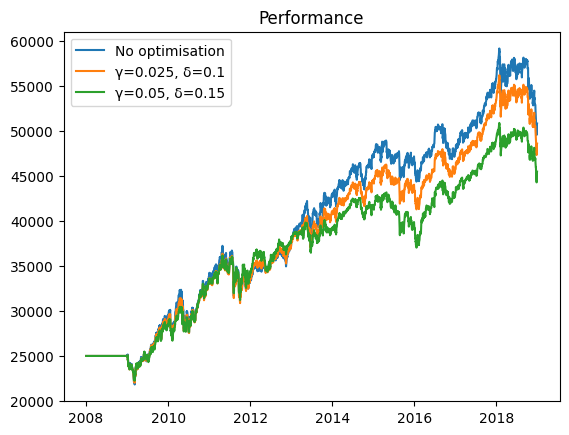

In [13]:
plt.plot(per1, label="No optimisation")
plt.plot(per2, label="γ=0.025, δ=0.1")
plt.plot(per3, label="γ=0.05, δ=0.15")
plt.legend()
plt.title("Performance")
plt.show()


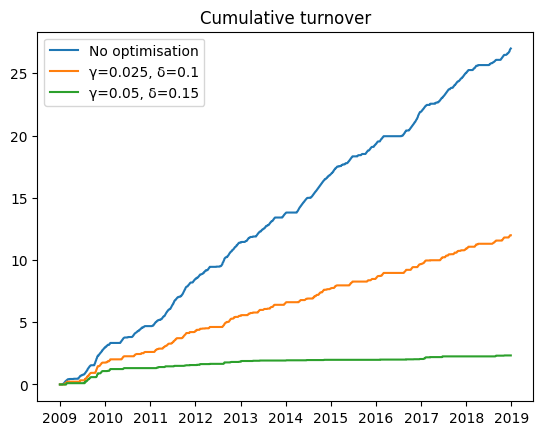

In [14]:
plt.plot(tv1, label="No optimisation")
plt.plot(tv2, label="γ=0.025, δ=0.1")
plt.plot(tv3, label="γ=0.05, δ=0.15")
plt.legend()
plt.title("Cumulative turnover")
plt.show()

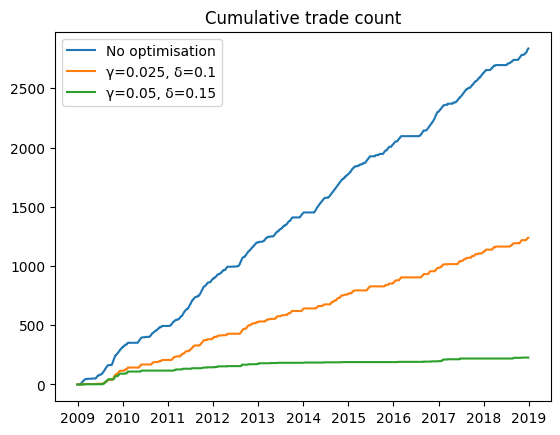

In [15]:
plt.plot(tc1, label="No optimisation")
plt.plot(tc2, label="γ=0.025, δ=0.1")
plt.plot(tc3, label="γ=0.05, δ=0.15")
plt.legend()
plt.title("Cumulative trade count")
plt.show()


# Discussion
Looking at the results and comparing it with the ones in the blog, the performance chart looks as expected. 

The cumumative turnover is also good except for the case of $\gamma=0.05, \delta=0.15$ which does not agree with the one in the blog. Also, the turnover definition excluded the fraction of 2 in the denominator to match the y-axis scale values from the blog result

The cumulative trade count do agree with the trend of the results in the blog except for the case of $\gamma=0.025, \delta=0.1$. But, the y-axis value are way off. If all 5 top ETFs are traded everyday for 10 years, the maximum possible trade count hits $5*365*10=18250$. But the values are around an order of magnitude less. (Also, the plots for cumulative turnover and cumulative trade count seem awfully similar)

Nevertheless, from comparing the different scenarios, it can be seen that the case of trade cost optimization does indeed allow for comparable performance with way less fewer trades!